In [2]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## Experiment 1 - Coupled Three Box

List of experiments:

a) Abrupt

b) High Emissions

c) Mid. Emissions

c) Overshoot

#### Setup and Run Experiments

In [21]:
# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 3

# Initialize forcing vectors and run scenarios
scenarios = ['Abrupt','High Emissions','Mid. Emissions','Overshoot']
forcings, full_outputs, T_out = {}, {}, {}
for i, scen in enumerate(scenarios):
  full_outputs[scen] = BudykoSellers.Run_Budyko_Sellers(scen_flag=i, n_boxes=n_boxes, diff_flag=1)
  forcings[scen] = np.tile(full_outputs[scen]['forcing_ts'], (n_boxes, 1))
  T_out[scen] = np.squeeze(full_outputs[scen]['T_ts'])[0:n_boxes,:]

### Method 1: Pattern Scaling

Train: Abrupt - L2 Error
	Test: Abrupt - [24.03418973 10.15246331 12.04513309]
	Test: High Emissions - [100.99038222  25.1204414   22.6905553 ]
	Test: Mid. Emissions - [58.73303679 15.62409265 17.85913364]
	Test: Overshoot - [69.83564237 19.0006429  21.52679674]
Train: High Emissions - L2 Error
	Test: Abrupt - [47.69047436 21.30088399 20.53701619]
	Test: High Emissions - [1.24157756 0.3136215  0.33370431]
	Test: Mid. Emissions - [36.17857665 12.4197412   7.24188698]
	Test: Overshoot - [50.11558507 17.98298878  9.66060862]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [36.5283669  14.87810561 18.10668648]
	Test: High Emissions - [33.56912937 10.53436917  4.26143783]
	Test: Mid. Emissions - [24.59645845  7.51857339  6.12420994]
	Test: Overshoot - [42.42420374 13.88459444  9.73440947]
Train: Overshoot - L2 Error
	Test: Abrupt - [36.75849775 14.21460985 19.40887475]
	Test: High Emissions - [32.82224961 11.77722356  1.95835787]
	Test: Mid. Emissions - [24.60356031  7.60864376  6.47732902

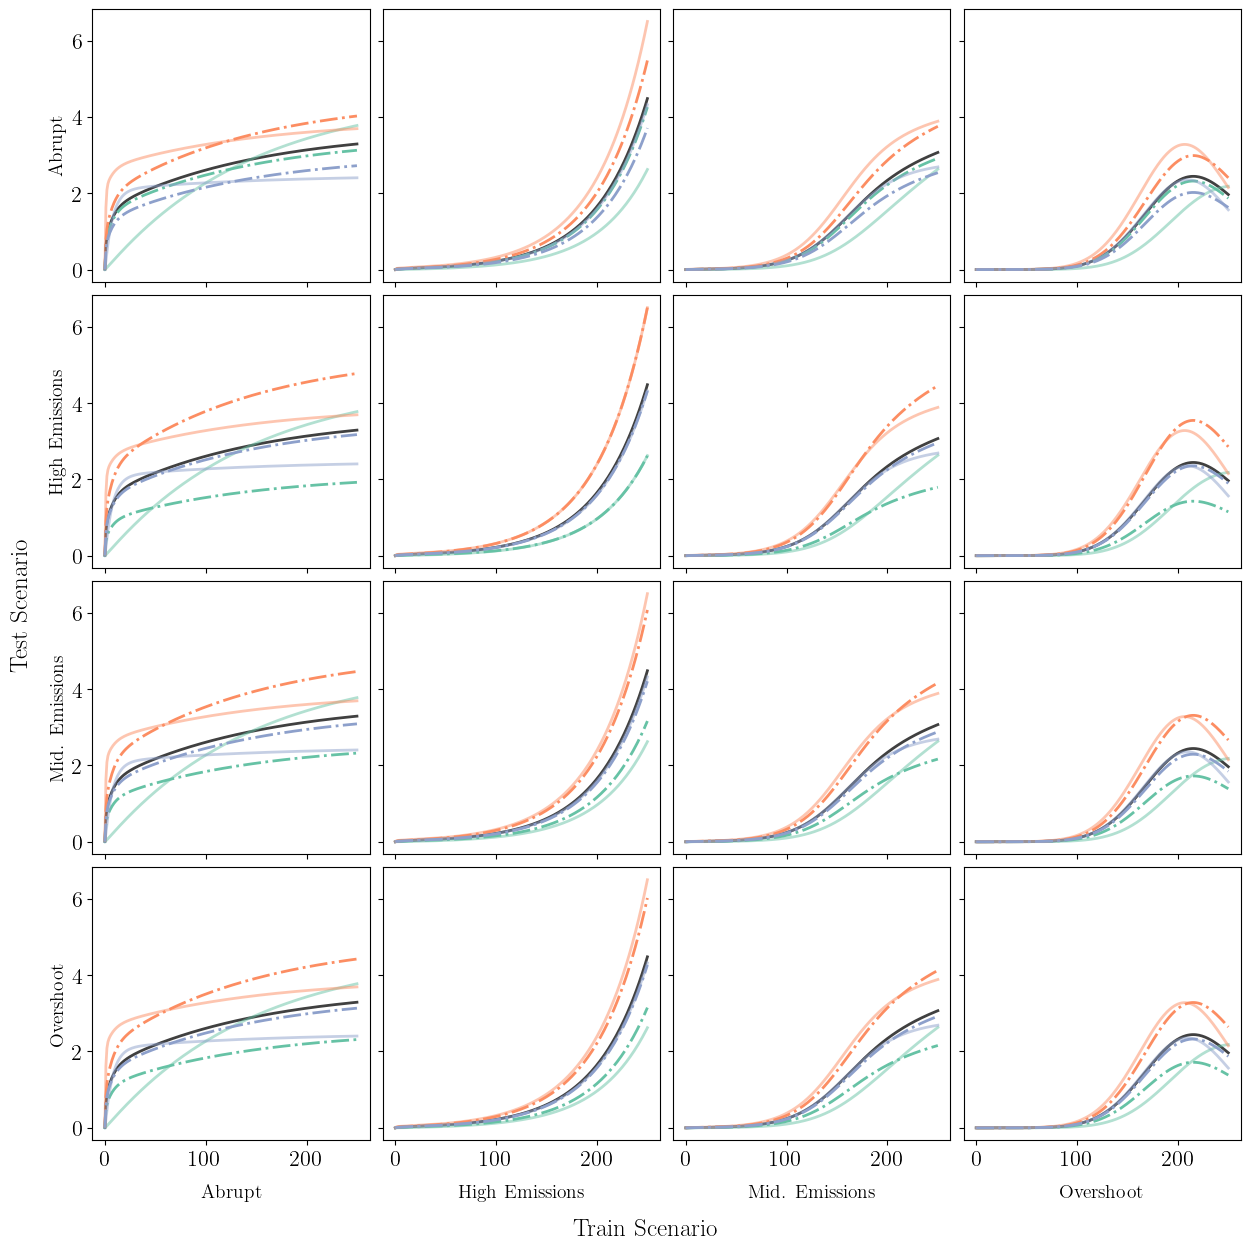

In [79]:
operator_PS, T_pred_PS, error_metrics_PS = emulator_utils.emulate_scenarios('PS', scenarios=scenarios, outputs=T_out, forcings=forcings)
emulator_utils.plot_true_pred(T_out, T_pred_PS, scenarios, operator='PS')

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_error_heatmap(error_metrics: dict,
                       exp: str,
                       method: str,
                       train_scenarios: list[str],
                       test_scenarios:  list[str],
                       cmap: str = "Reds",
                       vmax: float | None = None,
                       ax: plt.Axes | None = None,
                       save: bool = False,
                       long_title: str = 'Method X: ??') -> plt.Axes:
    """
    Plot a single heat-map of mean error values for one experiment / method.

    Parameters
    ----------
    error_metrics : dict
        error_metrics[method][exp][train][test] -> 1-D array-like of errors
        If *method* == "direct", the structure is
        error_metrics["direct"][exp][scenario] -> 1-D array-like.
    exp : str
        Experiment name (e.g. "2box", "3box").
    method : str
        One method key to visualise.
    train_scenarios, test_scenarios : list[str]
        Scenario labels that define the y- and x-axes of the heat-map.
    cmap : str, optional
        Matplotlib/Seaborn colour-map.  Default "Reds".
    vmax : float, optional
        Upper limit of the colour-bar.  If None, it is chosen automatically.
    ax : matplotlib.axes.Axes, optional
        Axis to draw on.  If omitted a new figure/axis is created.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axis containing the heat-map.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    # Build the matrix of *mean* errors
    data = np.empty((len(train_scenarios), len(test_scenarios)))

    for i, scen_train in enumerate(train_scenarios):
        for j, scen_test in enumerate(test_scenarios):
            if method == "direct":
                # 'direct' is only defined when train == test
                value = (np.mean(error_metrics["direct"][exp][scen_train])
                         if scen_train == scen_test else np.nan)
            else:
                # Average over the trailing dimension(s) (e.g., regions)
                value = np.mean(error_metrics[scen_train][scen_test])
            data[j, i] = value

    # Optionally cap the colour scale
    if vmax is None:
        vmax = np.nanmax(data)

    sns.heatmap(
        data,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        linewidth=0.5,
        annot=True,
        fmt=".2g",
        cbar_kws={"label": r"NRMSE [\%]"}
    )

    ax.set_xlabel("Train scenario",fontsize=24)
    ax.set_ylabel("Test scenario",fontsize=24)
    ax.set_xticklabels(['Abr.','Hi. Em.', 'Mid. Em.', 'Over.'], rotation=45, ha="right")
    ax.set_yticklabels(['Abr.','Hi. Em.', 'Mid. Em.', 'Over.'], rotation=45)
    ax.set_title(f'{long_title}')

    plt.tight_layout()

    if save:
        plt.savefig(f'Figures/error_{exp}_{method}.pdf',dpi=900)

    return ax


<Axes: title={'center': 'Method 1: Pattern Scaling'}, xlabel='Train scenario', ylabel='Test scenario'>

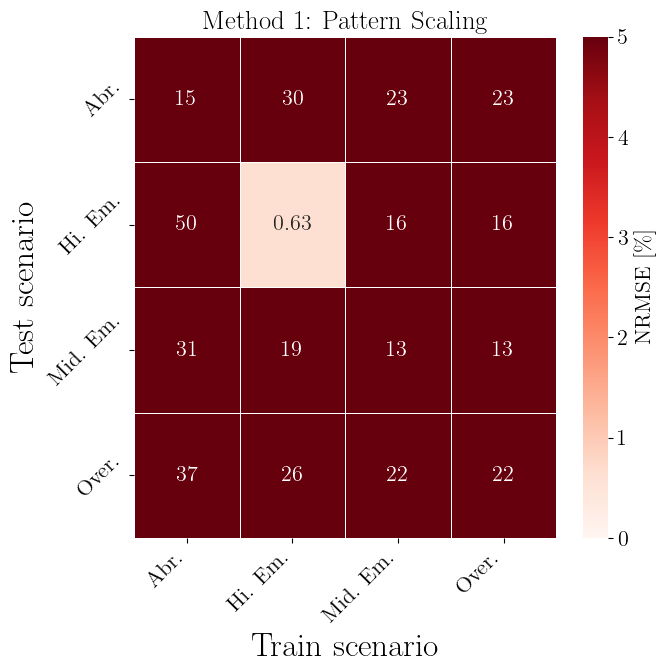

In [134]:
plot_error_heatmap(
    error_metrics   = error_metrics_PS,
    exp             = "3box_coup",
    method          = "PS",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = True,
    long_title = 'Method 1: Pattern Scaling'
)

### Method 2: General Quasi-Equilibrium

In [71]:
# Generate QE lookup table
QE_lookup = emulator_utils.generate_QE('3box_coup', F0=0, F1=10, N_step=100)

In [67]:
T_interp = QE_interp(QE_lookup, forcings['High Emissions'][0], 3)

Train: Abrupt - L2 Error
	Test: Abrupt - [103.63420785  22.99807145  18.71620928]
	Test: High Emissions - [483.7020131   58.68990177  47.89340402]
	Test: Mid. Emissions - [301.21170884  41.10214706  26.57603469]
	Test: Overshoot - [318.71491457  43.6647926   29.2176294 ]
Train: High Emissions - L2 Error
	Test: Abrupt - [103.63420785  22.99807145  18.71620928]
	Test: High Emissions - [483.7020131   58.68990177  47.89340402]
	Test: Mid. Emissions - [301.21170884  41.10214706  26.57603469]
	Test: Overshoot - [318.71491457  43.6647926   29.2176294 ]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [103.63420785  22.99807145  18.71620928]
	Test: High Emissions - [483.7020131   58.68990177  47.89340402]
	Test: Mid. Emissions - [301.21170884  41.10214706  26.57603469]
	Test: Overshoot - [318.71491457  43.6647926   29.2176294 ]
Train: Overshoot - L2 Error
	Test: Abrupt - [103.63420785  22.99807145  18.71620928]
	Test: High Emissions - [483.7020131   58.68990177  47.89340402]
	Test: Mid. Emissi

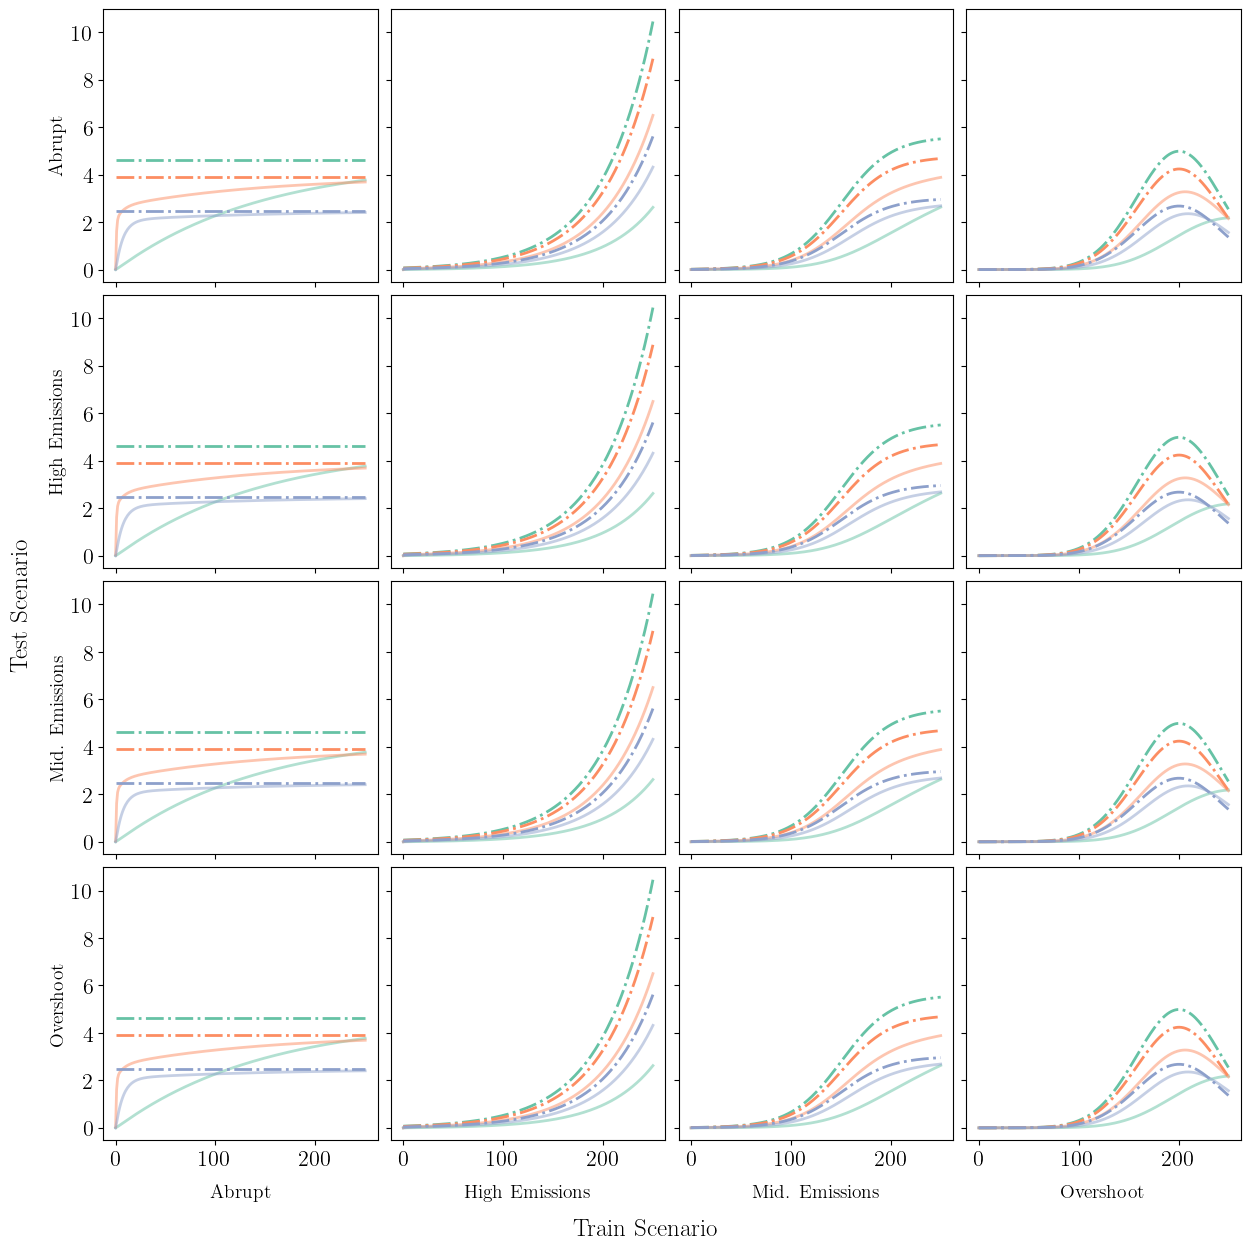

In [138]:
#Load QE lookup table
QE_lookup = emulator_utils.load_QE('3box_coup')

operator_QE, T_pred_QE, error_metrics_QE = emulator_utils.emulate_scenarios('QE', scenarios=scenarios, outputs=T_out, forcings=forcings, exp='3box_coup', n_boxes=n_boxes)
emulator_utils.plot_true_pred(T_out, T_pred_QE, scenarios)

<Axes: title={'center': 'Method 2: Quasi-Eq.'}, xlabel='Train scenario', ylabel='Test scenario'>

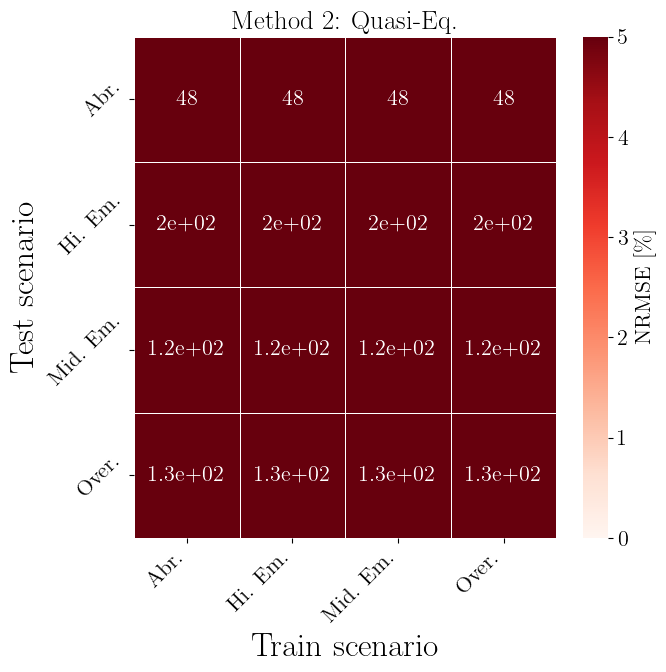

In [139]:
plot_error_heatmap(
    error_metrics   = error_metrics_QE,
    exp             = "3box_coup",
    method          = "QE",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = False,
    long_title = 'Method 2: Quasi-Eq.'
)

### Method 3: Fluctuation Dissipation Theorem

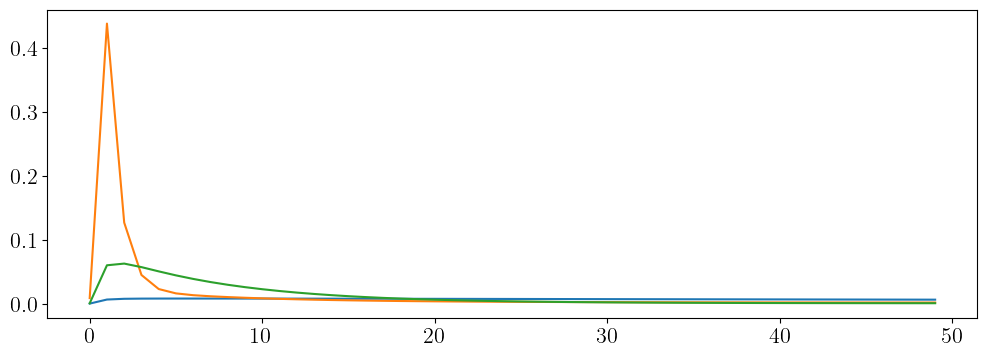

In [153]:
plt.plot(operator_direct.T[0:50])

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:330: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  grid, params, init, const, time = {}, {}, {}, {}, {}


Train: Impulse Forcing - L2 Error


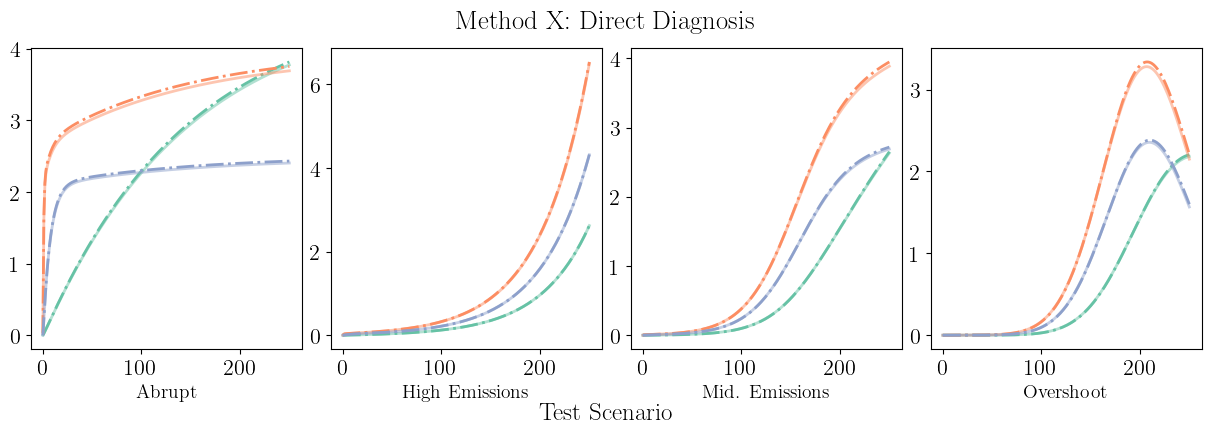

In [150]:
dt = 1
operator_direct, T_pred_direct, error_metrics_direct = emulator_utils.emulate_scenarios('direct', scenarios=scenarios, outputs=T_out, forcings=forcings, n_boxes=n_boxes, dt=dt, diff_flag=1)
emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, scenarios)

### Method 6: Dynamic Mode Decomposition (DMD)

Train: Abrupt - L2 Error
	Test: Abrupt - [0.00794683 0.06423648 0.01801414]
	Test: High Emissions - [1.65502953 1.87830153 1.65696023]
	Test: Mid. Emissions - [1.05030609 0.7946609  0.7289406 ]
	Test: Overshoot - [1.11538565 1.17415027 1.06796178]
Train: High Emissions - L2 Error
	Test: Abrupt - [1.13294138 1.18084258 1.05963111]
	Test: High Emissions - [0.00056159 0.00251121 0.00071712]
	Test: Mid. Emissions - [0.74873066 1.18674594 1.06370866]
	Test: Overshoot - [1.04967891 1.87495536 1.67119453]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [0.36232697 1.87420167 0.75962023]
	Test: High Emissions - [0.02890907 0.07633909 0.03755293]
	Test: Mid. Emissions - [0.00701962 0.01595093 0.01072175]
	Test: Overshoot - [0.01397967 0.02914343 0.02621319]
Train: Overshoot - L2 Error
	Test: Abrupt - [0.35282279 3.59504377 0.87409741]
	Test: High Emissions - [0.02465823 0.13890648 0.03459778]
	Test: Mid. Emissions - [0.00337581 0.02344343 0.00576897]
	Test: Overshoot - [0.00034296 0.00054205 0

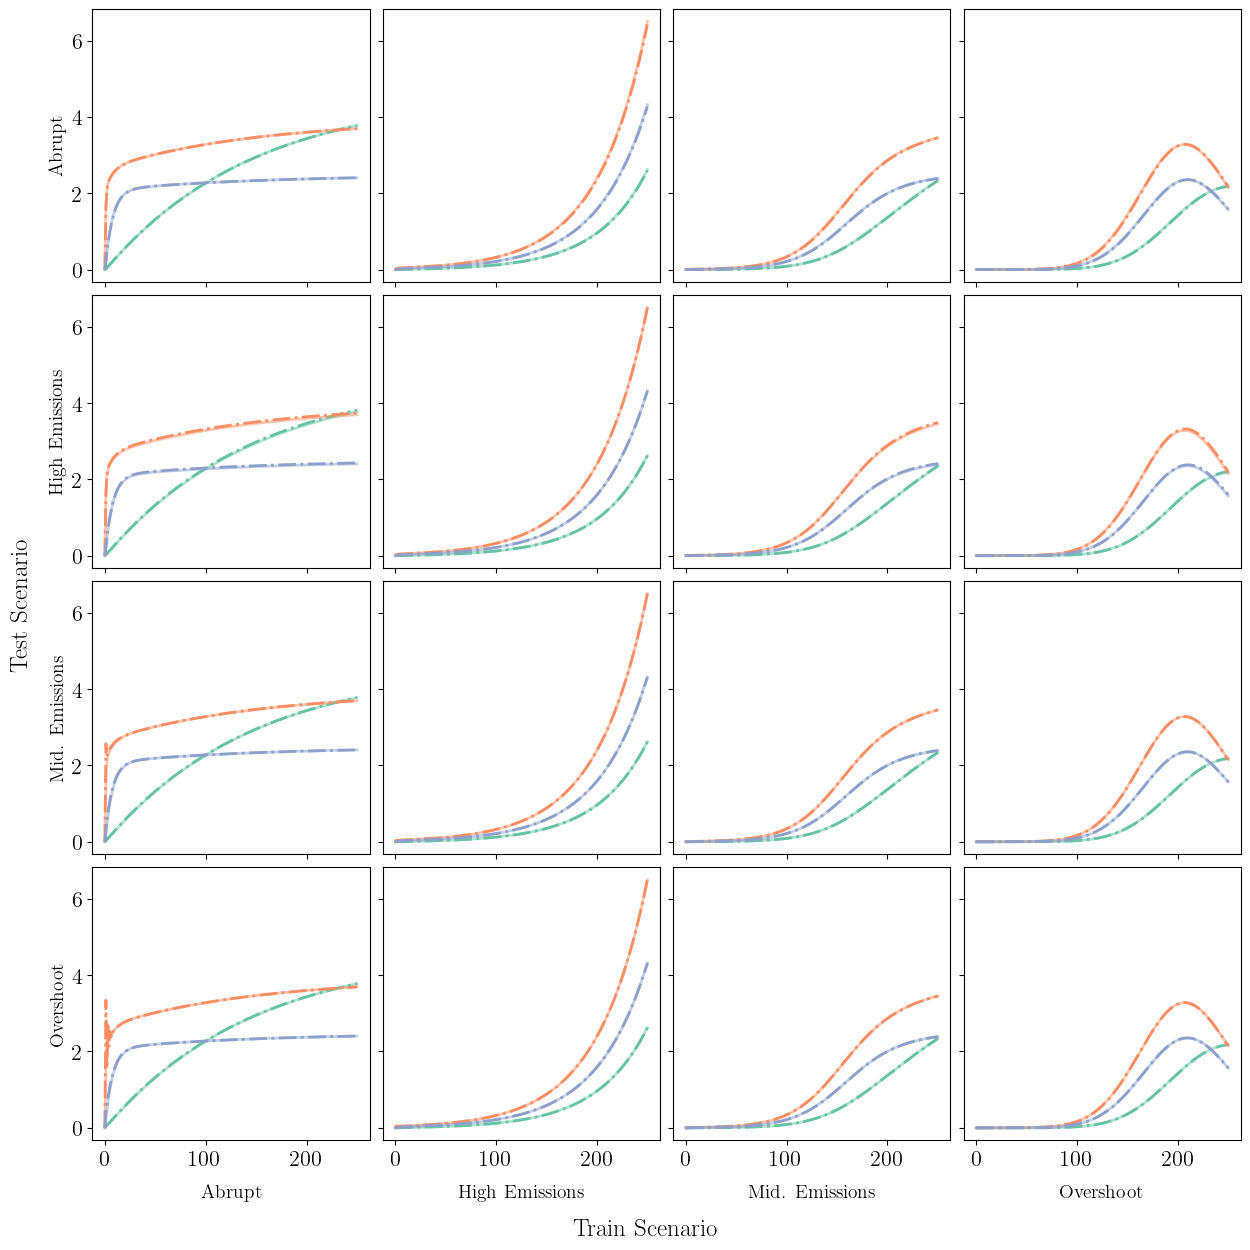

In [9]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_DMD, T_pred_DMD, error_metrics_DMD = emulator_utils.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
emulator_utils.plot_true_pred(T_out, T_pred_DMD, scenarios)

<Axes: title={'center': 'Method 6: DMD'}, xlabel='Train scenario', ylabel='Test scenario'>

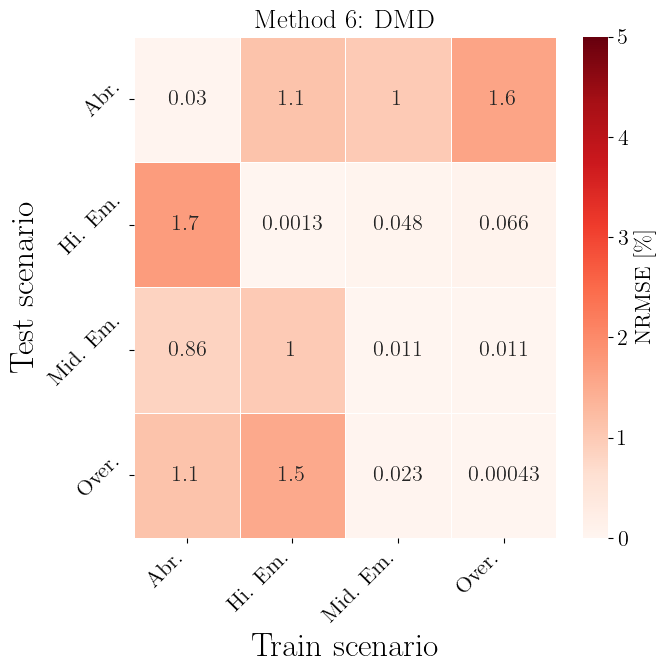

In [135]:
plot_error_heatmap(
    error_metrics   = error_metrics_DMD,
    exp             = "3box_coup",
    method          = "DMD",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = True,
    long_title = 'Method 6: DMD'
)

### Method 7: EDMD

Train: Abrupt - L2 Error
	Test: Abrupt - [0.00794683 0.06423648 0.01801414]
	Test: High Emissions - [1.65502953 1.87830153 1.65696023]
	Test: Mid. Emissions - [1.05030609 0.7946609  0.7289406 ]
	Test: Overshoot - [1.11538565 1.17415027 1.06796178]
Train: High Emissions - L2 Error
	Test: Abrupt - [1.13294138 1.18084258 1.05963111]
	Test: High Emissions - [0.00056159 0.00251121 0.00071712]
	Test: Mid. Emissions - [0.74873066 1.18674594 1.06370866]
	Test: Overshoot - [1.04967891 1.87495536 1.67119453]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [0.36232697 1.87420167 0.75962023]
	Test: High Emissions - [0.02890907 0.07633909 0.03755293]
	Test: Mid. Emissions - [0.00701962 0.01595093 0.01072175]
	Test: Overshoot - [0.01397967 0.02914343 0.02621319]
Train: Overshoot - L2 Error
	Test: Abrupt - [0.35282279 3.59504377 0.87409741]
	Test: High Emissions - [0.02465823 0.13890648 0.03459778]
	Test: Mid. Emissions - [0.00337581 0.02344343 0.00576897]
	Test: Overshoot - [0.00034296 0.00054205 0

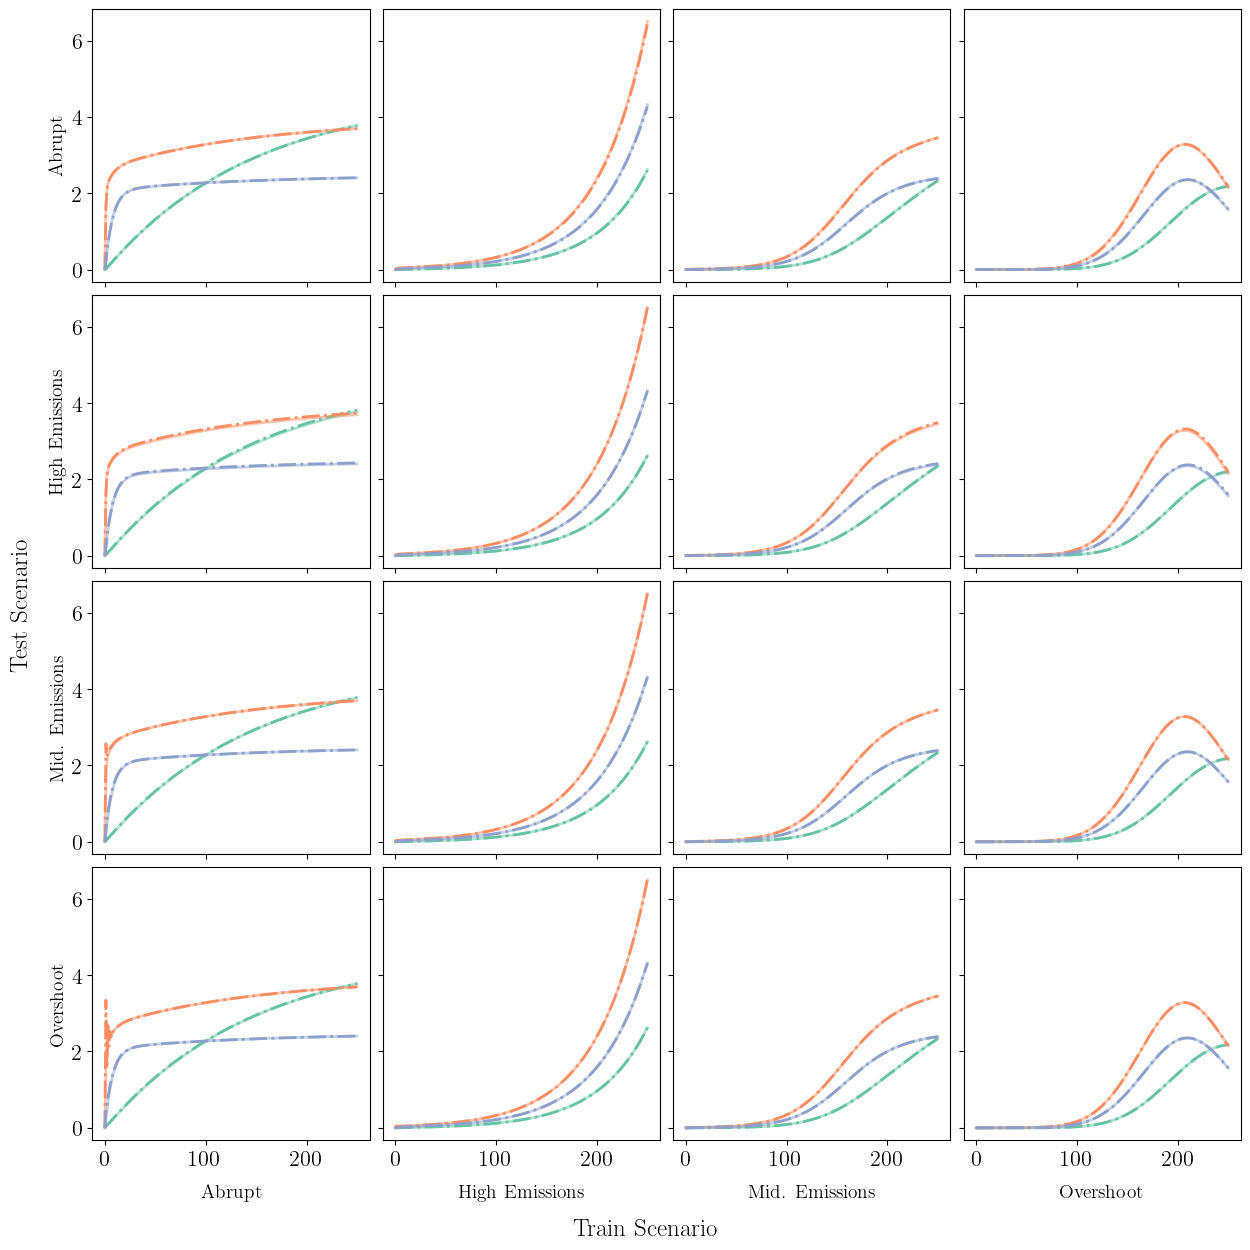

In [10]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
F_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
operator_EDMD, T_pred_EDMD, error_metrics_EDMD = emulator_utils.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
emulator_utils.plot_true_pred(T_out, T_pred_EDMD, scenarios)

### Method 4: Deconvolution

Train: Abrupt - L2 Error


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


	Test: Abrupt - [0.00389433 0.21093325 0.03815555]
	Test: High Emissions - [1.61639646 1.82759832 1.6189458 ]
	Test: Mid. Emissions - [1.02731259 0.77481192 0.71350954]
	Test: Overshoot - [1.09208416 1.14513571 1.0469338 ]
Train: High Emissions - L2 Error
	Test: Abrupt - [0.67635555 5.2188685  2.48872454]
	Test: High Emissions - [0.01497372 0.13562042 0.04717917]
	Test: Mid. Emissions - [0.29313053 4.5890856  2.36156715]
	Test: Overshoot - [0.40045385 7.36473608 3.73704935]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [8.94885083 5.23561943 2.14305261]
	Test: High Emissions - [1.13699695 0.6684534  0.29045431]
	Test: Mid. Emissions - [0.0193505  0.15092274 0.03850149]
	Test: Overshoot - [0.37932758 0.3901539  0.14085784]
Train: Overshoot - L2 Error
	Test: Abrupt - [16.20880113  8.00658538  2.29674323]
	Test: High Emissions - [3.02240599 1.98254774 0.442803  ]
	Test: Mid. Emissions - [1.3705696  0.59573474 0.26717144]
	Test: Overshoot - [0.14373264 0.66902328 0.2532295 ]


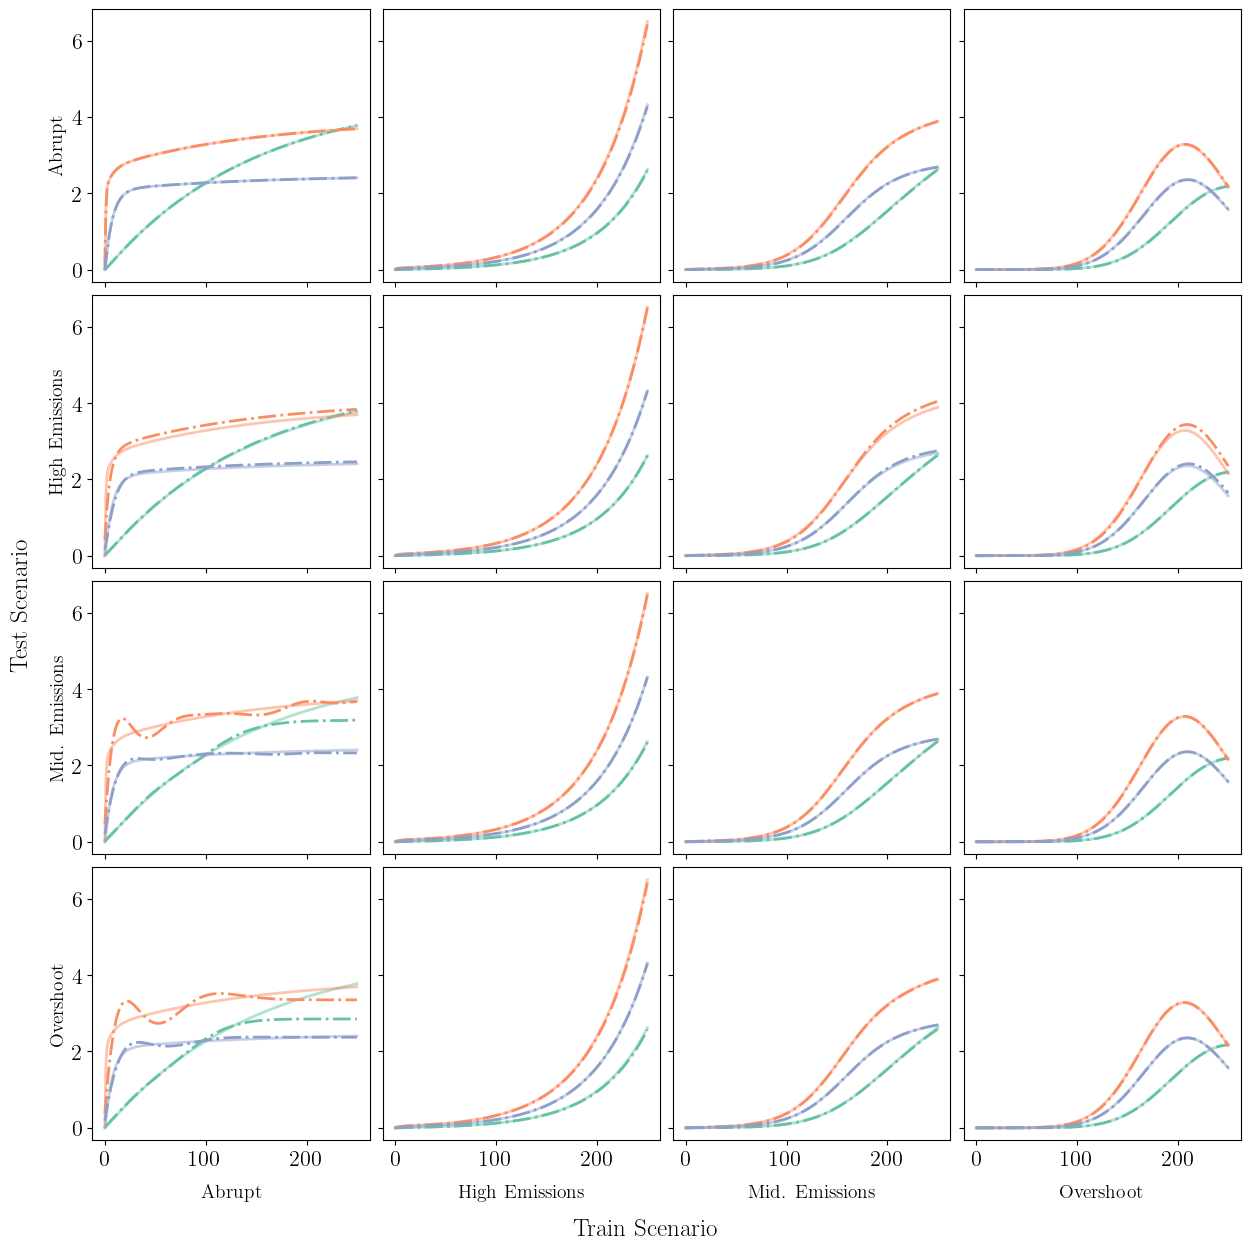

In [156]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out, forcings=forcings, dt=dt, regularize=True)
emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, scenarios)

<Axes: title={'center': 'Method 4: Deconvolution'}, xlabel='Train scenario', ylabel='Test scenario'>

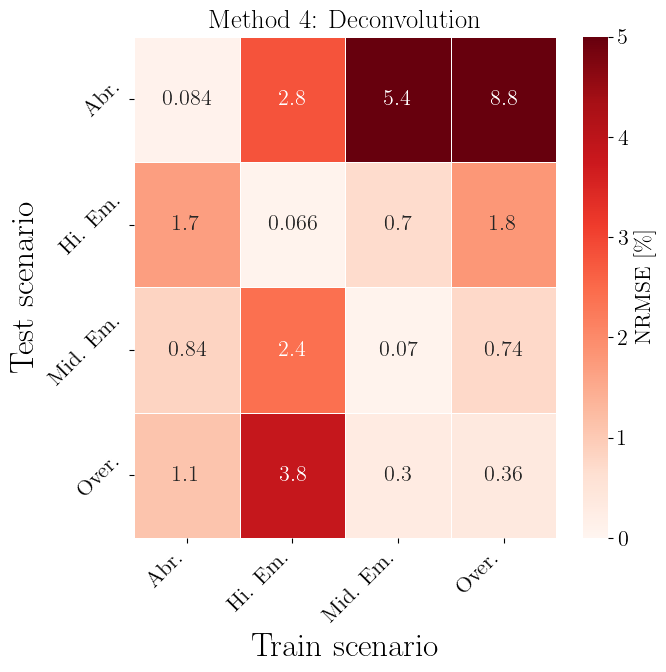

In [157]:
plot_error_heatmap(
    error_metrics   = error_metrics_deconvolve,
    exp             = "3box_coup",
    method          = "deconv",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = False,
    long_title = 'Method 4: Deconvolution'
)

### Method 5: Exponential Fit

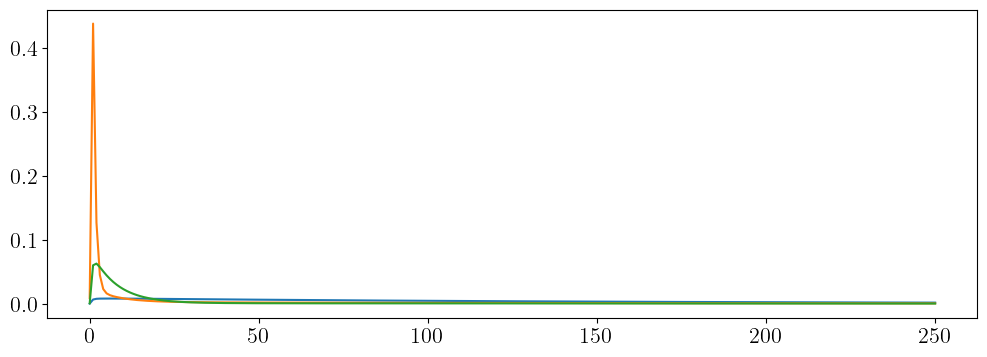

In [16]:
plt.plot(operator_direct.T)

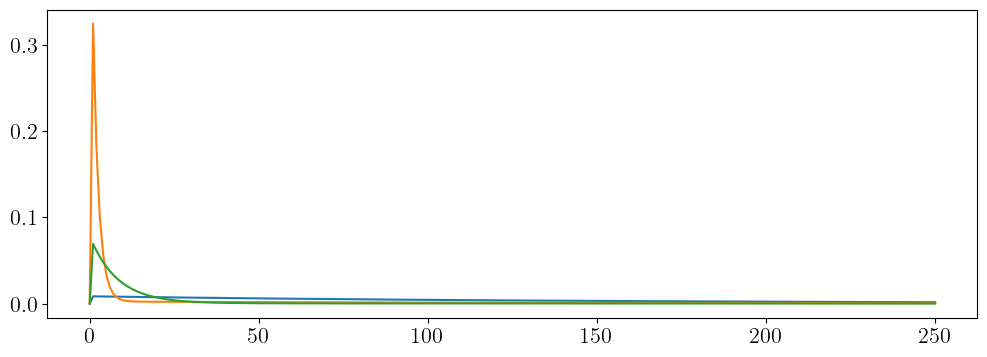

In [21]:
plt.plot(operator_fit['2xCO2'].T)

Train: Abrupt - L2 Error
[  4.774601   -13.72054    -12.554692    -6.0260205    0.5379371
 -10.653905    -7.961101   -12.623257     2.5517287   -5.006873
  -0.51783866  -2.0914643 ]
	Test: Abrupt - [0.28496813 1.63906248 1.66647469]
	Test: High Emissions - [0.23717574 0.10033448 0.98667712]
	Test: Mid. Emissions - [0.37214335 0.79326807 1.60102887]
	Test: Overshoot - [0.45083118 1.17123624 2.36380623]
Train: High Emissions - L2 Error
[  5.0020075 -13.831814  -13.602336  -10.185218    1.2541285 -11.176974
 -11.174668  -13.199589    3.6788363  -6.7764163  -1.2313735  -3.5774767]
	Test: Abrupt - [29.38066665 10.32307578 35.4623965 ]
	Test: High Emissions - [0.89779322 1.40157068 0.59397812]
	Test: Mid. Emissions - [ 6.54012978  3.38006251 27.49758018]
	Test: Overshoot - [ 7.88455151  5.51688181 40.70707306]
Train: Mid. Emissions - L2 Error
[  4.8290596 -13.804467  -13.539325   -6.5792155   1.360649  -11.206594
 -11.265034  -13.07763     2.6526945  -5.25772    -1.2343129  -2.224099 ]
	Test

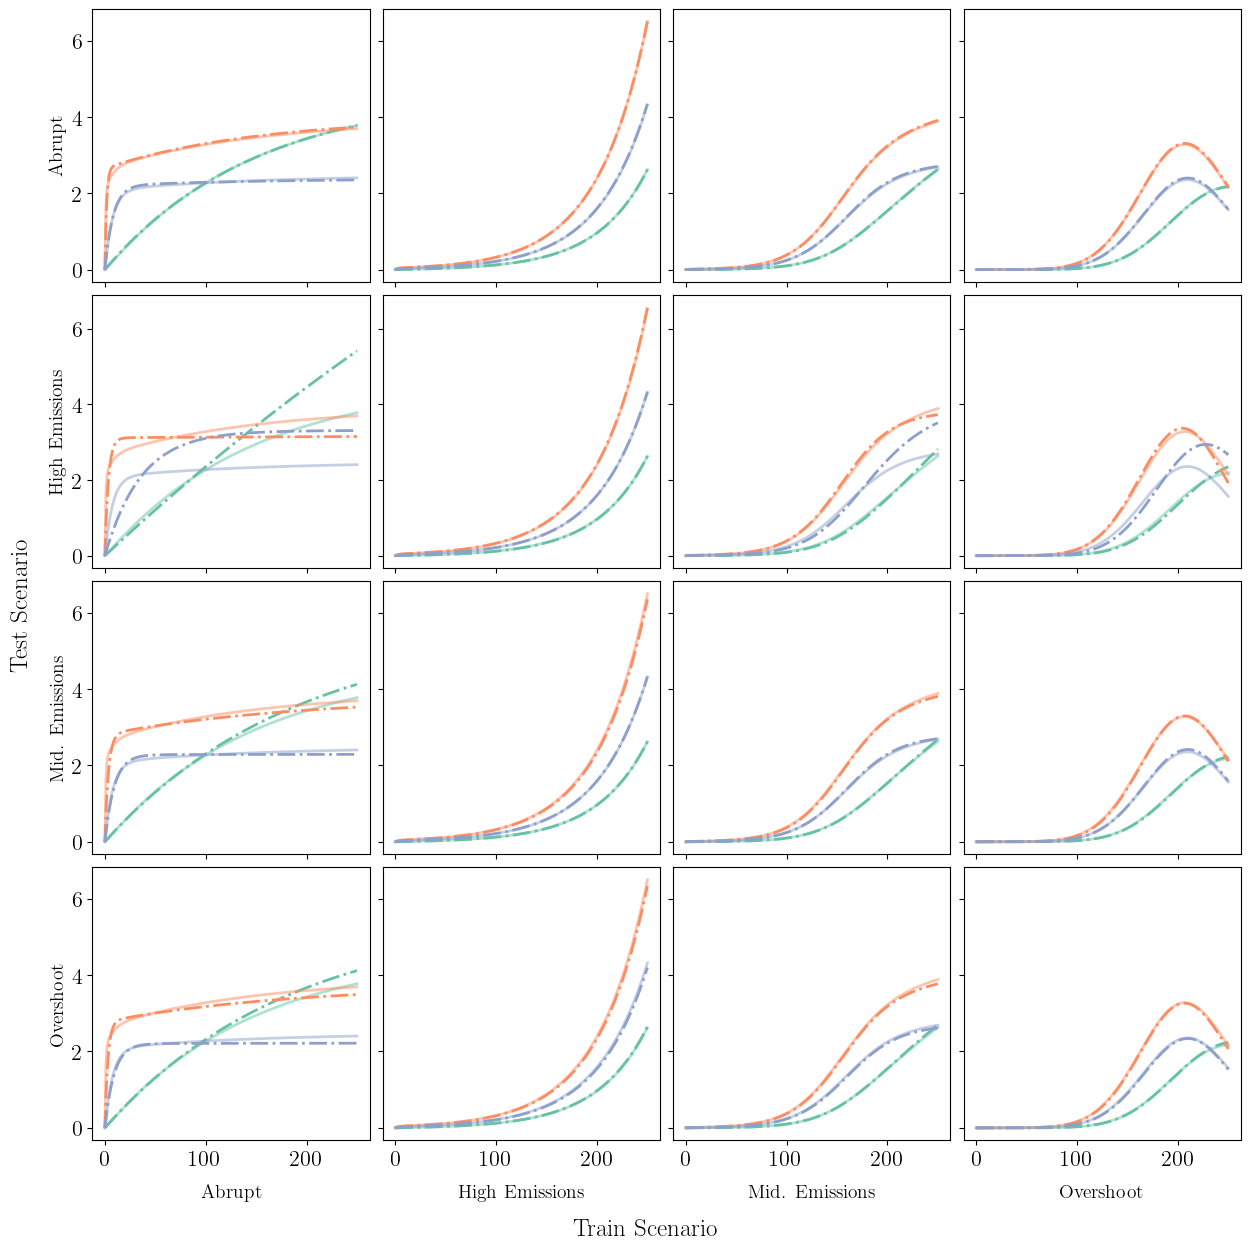

In [130]:
operator_fit, T_pred_fit, error_metrics_fit = emulator_utils.emulate_scenarios('fit_amp', scenarios=scenarios, outputs=T_out, forcings=forcings, t=t, dt=dt, n_boxes=n_boxes, n_modes=3, B=np.ones(n_boxes))
emulator_utils.plot_true_pred(T_out, T_pred_fit, scenarios)

<Axes: title={'center': 'Method 5: Modal Fit'}, xlabel='Train scenario', ylabel='Test scenario'>

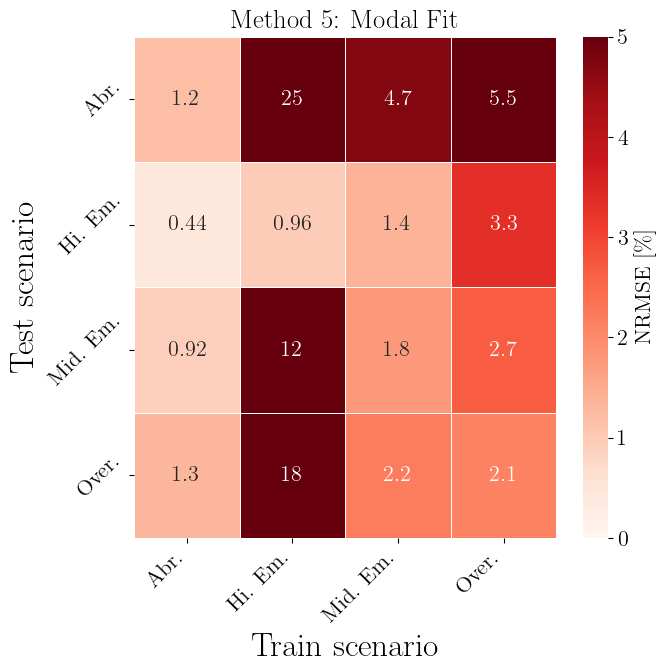

In [132]:
plot_error_heatmap(
    error_metrics   = error_metrics_fit,
    exp             = "3box_coup",
    method          = "fit",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = True,
    long_title = 'Method 5: Modal Fit'
)